 <font size="3">Test `TimeseriesExtractor` using the test dataset if not using a Windows machine since pybids is needed.</font>

In [1]:
import os, sys, warnings, nibabel as nib
warnings.simplefilter('ignore')
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts
import numpy as np, joblib, neurocaps
np.random.seed(50)

parcel_approach = {"Schaefer": {"n_rois": 100}}
#parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = parcel_approach["Schaefer"]["n_rois"] if "Schaefer" in parcel_approach.keys() else 116

if sys.platform != "win32":
    if os.path.basename(os.path.dirname(__vsc_ipynb_file__)) == "neurocaps":
        bids_dir = "tests/ds000031_R1.0.4_ses001-022/ds000031_R1.0.4/"
        pipeline_name = "fmriprep_1.0.0/fmriprep"
        confounds=["Cosine*", "aComp*", "Rot*"]

        extractor = TimeseriesExtractor(parcel_approach=parcel_approach, standardize="zscore_sample",
                                        use_confounds=True, detrend=False, low_pass=0.15, high_pass=None,
                                        confound_names=confounds)

        extractor.get_bold(bids_dir=bids_dir, session='002', runs="001",task="rest", pipeline_name=pipeline_name,tr=1.2)

In [2]:
print(neurocaps.__version__)

0.15.2


 <font size="3">Create random data. The `subject_timeseries` property is were the extracted timeseries data is stored and is also a setter. For demonstration purposes, random data is created to use for the `CAP` class to show various configurations and to be able to use the demo on Windows since `TimeseriesExtractor.get_bold()` uses pybids.</font>

In [3]:
extractor = TimeseriesExtractor(parcel_approach=parcel_approach)
extractor.subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,ncol) for y in range(1,4)} for x in range(1,11)}


List of confound regressors that will be used during timeseries extraction if available in confound
dataframe - ['cosine*', 'trans_x', 'trans_x_derivative1', 'trans_y', 'trans_y_derivative1', 'trans_z', 'trans_z_derivative1', 'rot_x', 'rot_x_derivative1', 'rot_y', 'rot_y_derivative1', 'rot_z', 'rot_z_derivative1', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05'].


 <font size="3">Creating a pickle file of the `subject_timeseries` using `self.timeseries_to_pickle`.</font>

In [4]:
output_dir = os.path.dirname(__vsc_ipynb_file__)

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_for_neurocaps_demo_timeseries.pkl")

with open("sample_for_neurocaps_demo_timeseries.pkl", "rb") as f:
    subject_timeseries = joblib.load(f)


 <font size="3">Visualizing bold with the `visualize_bold` method from `TimeseriesExtractor`.</font>

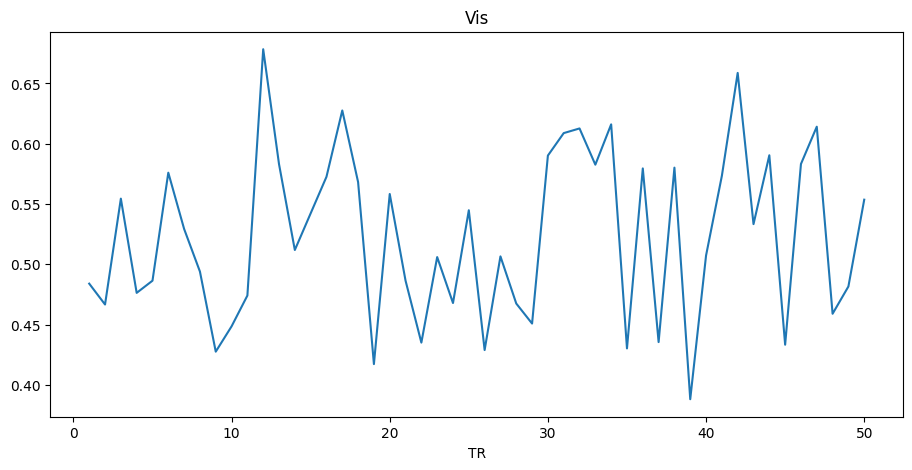

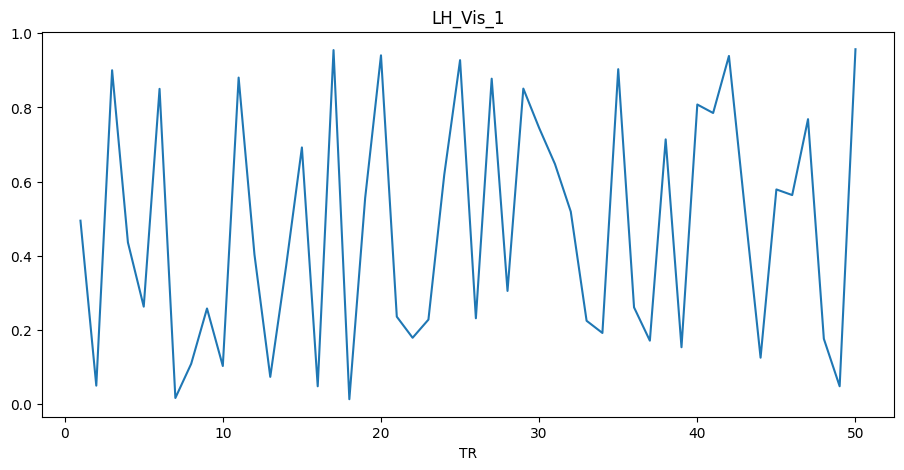

In [5]:
if ncol == 116:
    extractor.visualize_bold(subj_id="1",run=1, region="Cerebelum")
    extractor.visualize_bold(subj_id="1",run=1, roi_indx=0)
else:
    extractor.visualize_bold(subj_id="1",run=1, region="Vis")
    extractor.visualize_bold(subj_id="1",run=1, roi_indx="LH_Vis_1")

 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method. Additional options for `cluster_selection_method` includes the "silhouette", "davies_bouldin", and "variance_ratio". Additionally, visualizations from any method that produces them can be saved using `output_dir`, all methods have docstrings explaining their purpose, available parameters, kwargs, and properties (in the case of classes),</font>

[GROUP: High ADHD | METHOD: elbow] - Optimal cluster size is 21.


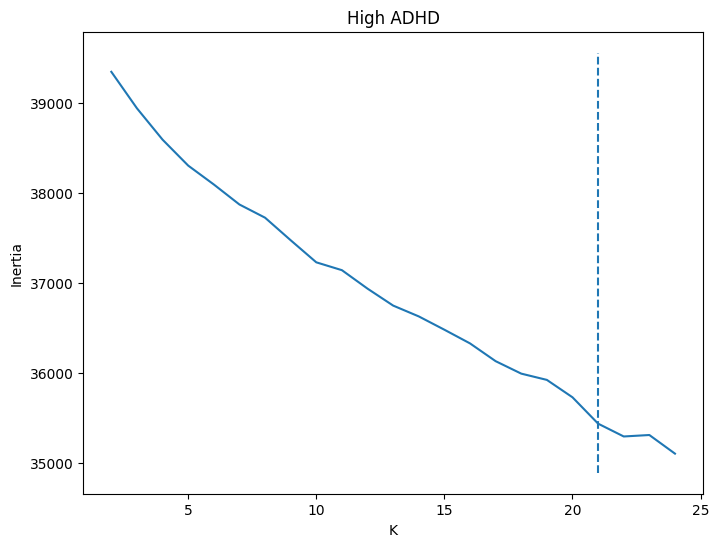

[GROUP: Low ADHD | METHOD: elbow] - Optimal cluster size is 16.


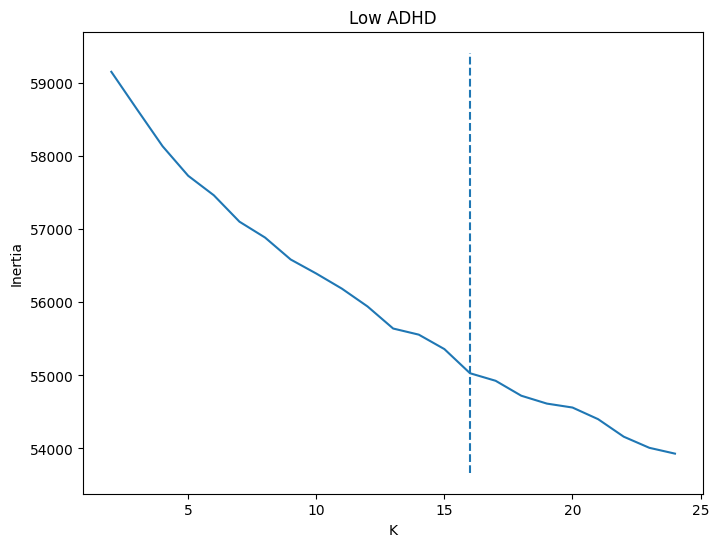

{'High ADHD': KMeans(max_iter=100, n_clusters=21, random_state=50), 'Low ADHD': KMeans(max_iter=100, n_clusters=16, random_state=50)}
{'High ADHD': 21, 'Low ADHD': 16}


In [6]:
cap_analysis = CAP(groups={"High ADHD": ["1","2","3","5"], "Low ADHD": ["4","6","7","8","9","10"]})
cap_analysis.get_caps(subject_timeseries=subject_timeseries, runs=[1,2],
                      n_clusters=list(range(2,25)), cluster_selection_method="elbow", show_figs=True,
                      random_state=50, max_iter=100, init="k-means++")
print(cap_analysis.kmeans)
print(cap_analysis.optimal_n_clusters)

 <font size="3">Getting CAP metrics using the `calculate_metrics` method. Values assigned at NaN is just to indicate that a group does not have a particular CAP. This done to differentiate it from 0, which indicates a particular CAP did not appear in a subject. Note, all groups are in the same dataframe for simplicity but use their own kmeans models.</font>

In [7]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7,...,CAP-12,CAP-13,CAP-14,CAP-15,CAP-16,CAP-17,CAP-18,CAP-19,CAP-20,CAP-21
0,1,High_ADHD,run-1,0.00,0.08,0.06,0.06,0.04,0.04,0.04,...,0.02,0.04,0.10,0.02,0.10,0.02,0.04,0.00,0.12,0.00
1,1,High_ADHD,run-2,0.00,0.02,0.06,0.08,0.04,0.02,0.08,...,0.00,0.06,0.06,0.00,0.12,0.04,0.02,0.00,0.06,0.00
2,1,High_ADHD,run-3,0.00,0.02,0.18,0.04,0.04,0.00,0.04,...,0.04,0.00,0.04,0.00,0.08,0.04,0.00,0.00,0.04,0.00
3,2,High_ADHD,run-1,0.00,0.06,0.08,0.12,0.00,0.00,0.10,...,0.06,0.04,0.12,0.00,0.12,0.04,0.00,0.00,0.08,0.02
4,2,High_ADHD,run-2,0.02,0.02,0.08,0.08,0.02,0.06,0.04,...,0.04,0.02,0.00,0.02,0.10,0.08,0.02,0.00,0.08,0.02
5,2,High_ADHD,run-3,0.00,0.12,0.12,0.08,0.06,0.02,0.04,...,0.02,0.06,0.04,0.02,0.12,0.02,0.02,0.00,0.04,0.00
6,3,High_ADHD,run-1,0.00,0.06,0.10,0.04,0.00,0.06,0.04,...,0.00,0.02,0.02,0.02,0.12,0.04,0.00,0.02,0.12,0.00
7,3,High_ADHD,run-2,0.02,0.06,0.08,0.08,0.02,0.00,0.02,...,0.02,0.00,0.08,0.02,0.10,0.04,0.04,0.04,0.08,0.00
8,3,High_ADHD,run-3,0.00,0.02,0.20,0.08,0.02,0.02,0.06,...,0.00,0.00,0.06,0.00,0.06,0.04,0.00,0.00,0.16,0.00
9,5,High_ADHD,run-1,0.00,0.04,0.04,0.04,0.02,0.00,0.04,...,0.00,0.00,0.04,0.04,0.10,0.08,0.02,0.06,0.04,0.02


 <font size="3">The `subject_table` property in the `CAP` class also acts has a setter and can be used to add an additional subject.</font>

In [8]:
subject_table = cap_analysis.subject_table
subject_table.update({"11": "High ADHD"})
cap_analysis.subject_table = subject_table
cap_analysis.subject_table

{'1': 'High ADHD',
 '2': 'High ADHD',
 '3': 'High ADHD',
 '5': 'High ADHD',
 '4': 'Low ADHD',
 '6': 'Low ADHD',
 '7': 'Low ADHD',
 '8': 'Low ADHD',
 '9': 'Low ADHD',
 '10': 'Low ADHD',
 '11': 'High ADHD'}

In [9]:
subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,ncol) for y in range(1,4)} for x in range(1,12)}
cap_analysis.calculate_metrics(subject_timeseries=subject_timeseries, metrics="counts")["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7,...,CAP-12,CAP-13,CAP-14,CAP-15,CAP-16,CAP-17,CAP-18,CAP-19,CAP-20,CAP-21
0,1,High_ADHD,run-1,0,2,5,4,0,0,2,...,0,1,4,0,8,4.0,0.0,0.0,6.0,0.0
1,1,High_ADHD,run-2,0,1,9,5,1,0,2,...,0,1,3,1,6,4.0,0.0,1.0,3.0,0.0
2,1,High_ADHD,run-3,0,4,5,3,1,1,1,...,0,1,3,0,5,5.0,0.0,2.0,5.0,0.0
3,2,High_ADHD,run-1,0,2,3,2,3,0,1,...,2,1,4,0,2,5.0,1.0,1.0,3.0,0.0
4,2,High_ADHD,run-2,0,3,4,3,1,0,1,...,0,2,2,1,8,1.0,0.0,0.0,5.0,0.0
5,2,High_ADHD,run-3,0,2,4,3,2,0,4,...,1,1,4,1,2,1.0,0.0,0.0,2.0,0.0
6,3,High_ADHD,run-1,0,0,8,2,3,0,2,...,1,3,2,0,4,3.0,0.0,0.0,3.0,0.0
7,3,High_ADHD,run-2,0,0,5,3,1,0,7,...,1,3,2,0,6,3.0,0.0,0.0,5.0,0.0
8,3,High_ADHD,run-3,0,5,2,5,2,3,3,...,0,0,1,0,8,4.0,0.0,2.0,2.0,0.0
9,5,High_ADHD,run-1,0,4,6,2,0,1,2,...,0,1,3,0,7,3.0,1.0,0.0,7.0,0.0


 <font size="3">Using the the pickled subject timeseries as an input instead. All `subject_timeseries` parameters in the `neurocaps` class accepts pickles.</font>

[GROUP: High ADHD | METHOD: silhouette] - Optimal cluster size is 2.


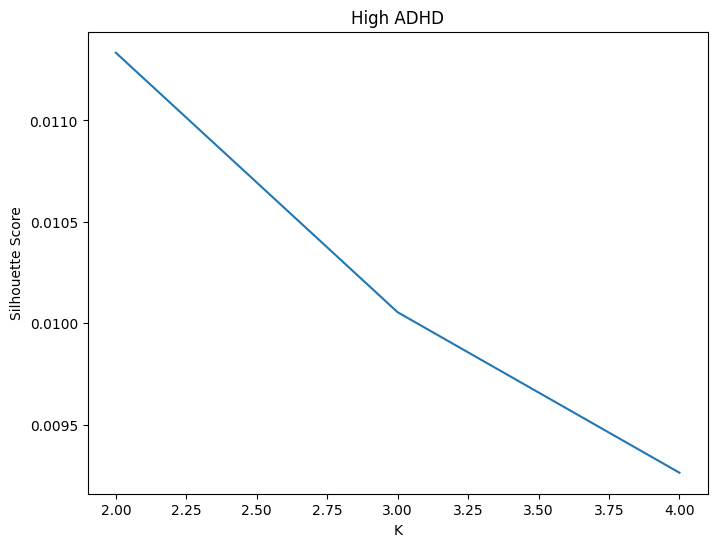

[GROUP: Low ADHD | METHOD: silhouette] - Optimal cluster size is 2.


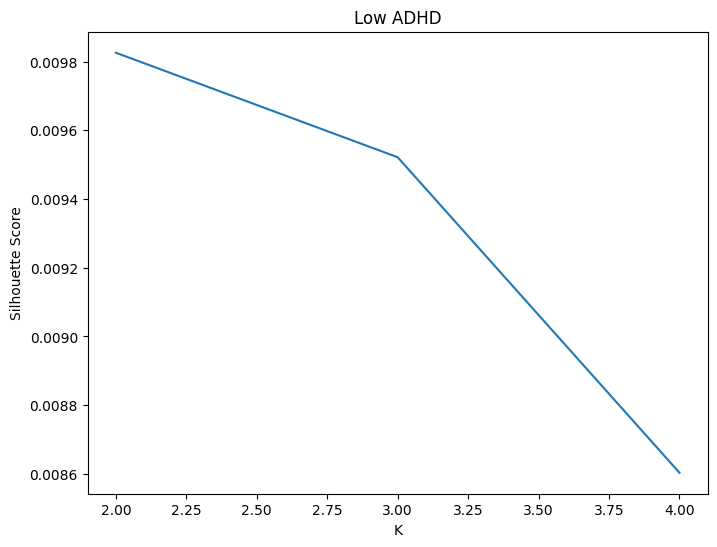

{'High ADHD': KMeans(n_clusters=2), 'Low ADHD': KMeans(n_clusters=2)}

In [10]:
cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl",
                      n_clusters=list(range(2,5)),
                      cluster_selection_method="silhouette", show_figs=True)
cap_analysis.kmeans

In [11]:
cap_analysis.calculate_metrics(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl", metrics="counts")

{'counts':    Subject_ID      Group    Run  CAP-1  CAP-2
 0           1  High_ADHD  run-1     24     26
 1           1  High_ADHD  run-2     26     24
 2           1  High_ADHD  run-3     31     19
 3           2  High_ADHD  run-1     20     30
 4           2  High_ADHD  run-2     25     25
 5           2  High_ADHD  run-3     29     21
 6           3  High_ADHD  run-1     29     21
 7           3  High_ADHD  run-2     19     31
 8           3  High_ADHD  run-3     26     24
 9           5  High_ADHD  run-1     31     19
 10          5  High_ADHD  run-2     30     20
 11          5  High_ADHD  run-3     27     23
 12          4   Low_ADHD  run-1     30     20
 13          4   Low_ADHD  run-2     25     25
 14          4   Low_ADHD  run-3     25     25
 15          6   Low_ADHD  run-1     30     20
 16          6   Low_ADHD  run-2     26     24
 17          6   Low_ADHD  run-3     24     26
 18          7   Low_ADHD  run-1     28     22
 19          7   Low_ADHD  run-2     28     22
 20

 <font size="3">`parcel_approach` can be during initialization of the `CAP` class or later when needed for visualization purposes. When setting the `parcel_approach` using the `self.parcel_approach` property pickles can be used to. This makes it easier if you are using a parcellation outside of Schaefer or AAL or you are using a modified version of these parcellations.</font>

In [12]:
cap_analysis.parcel_approach = parcel_approach

 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `caps2plot` method.</font>

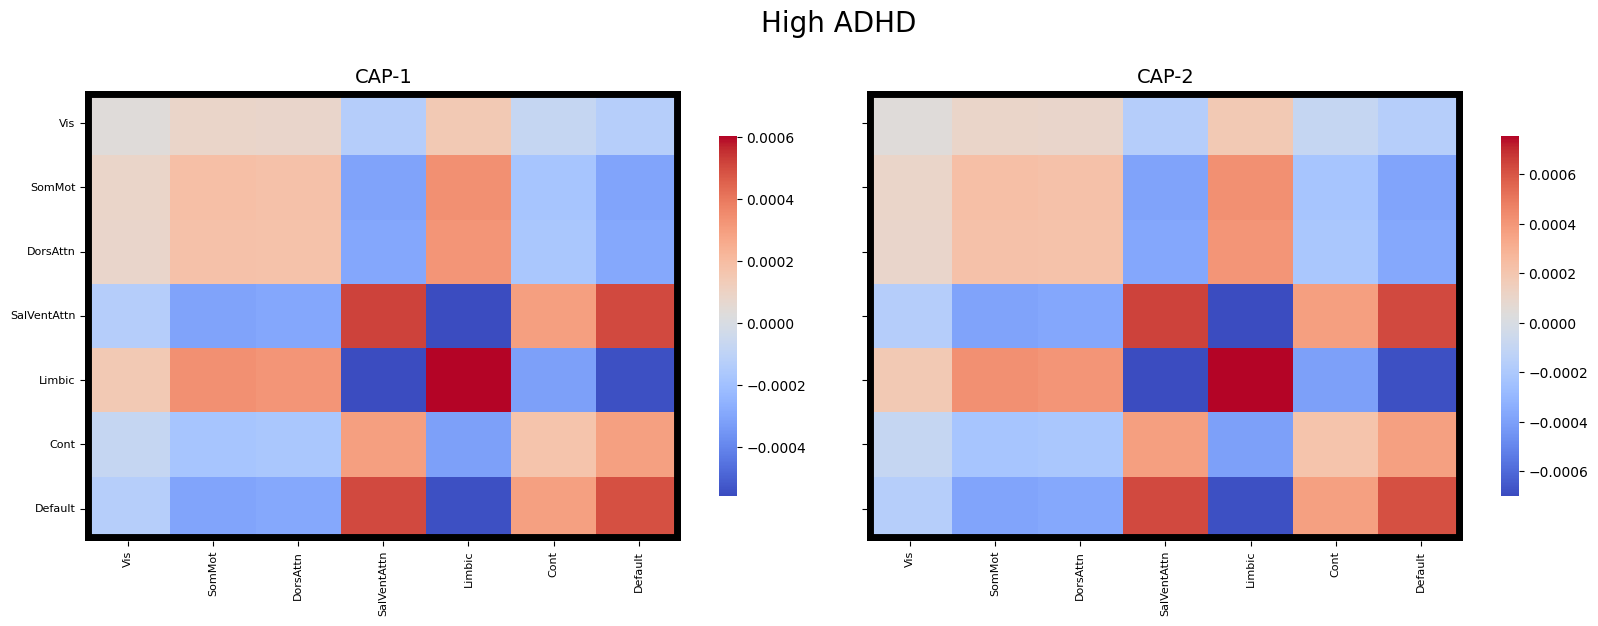

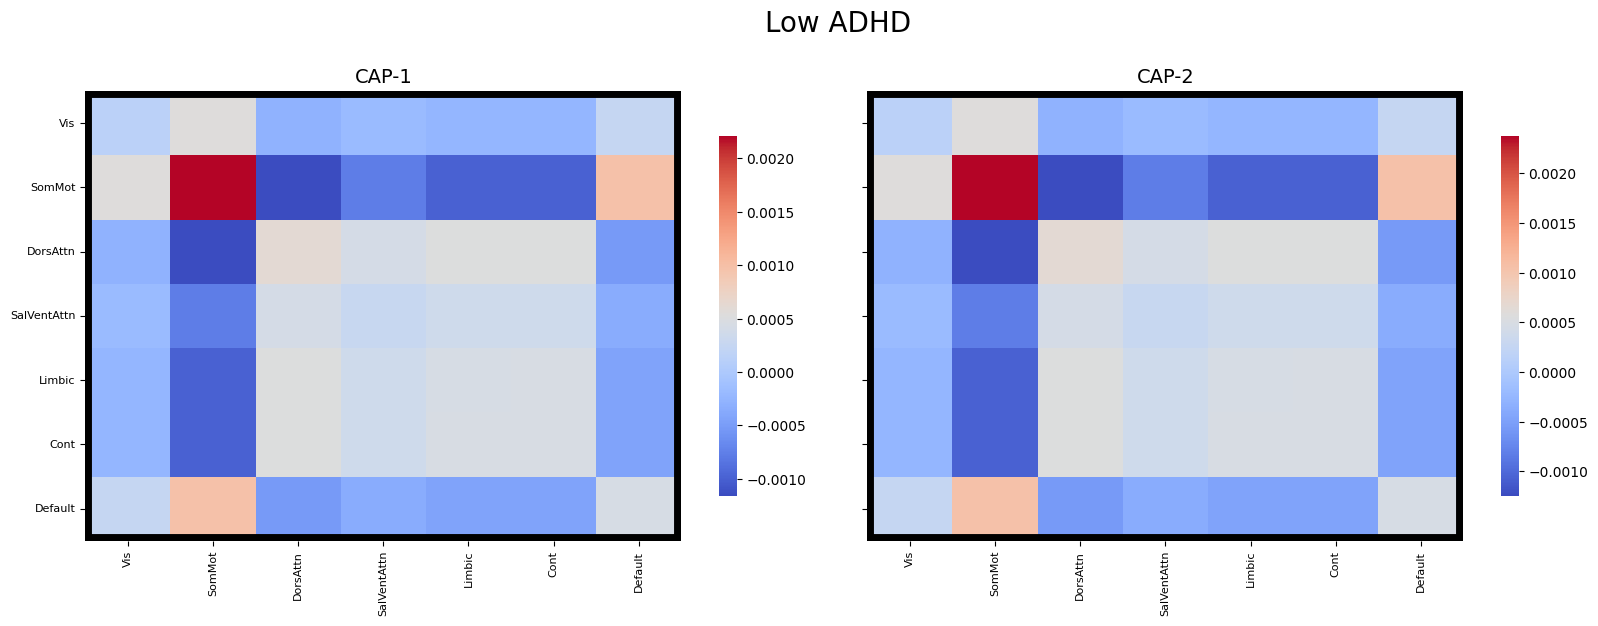

In [13]:
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10)

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `caps2plot` method.</font>

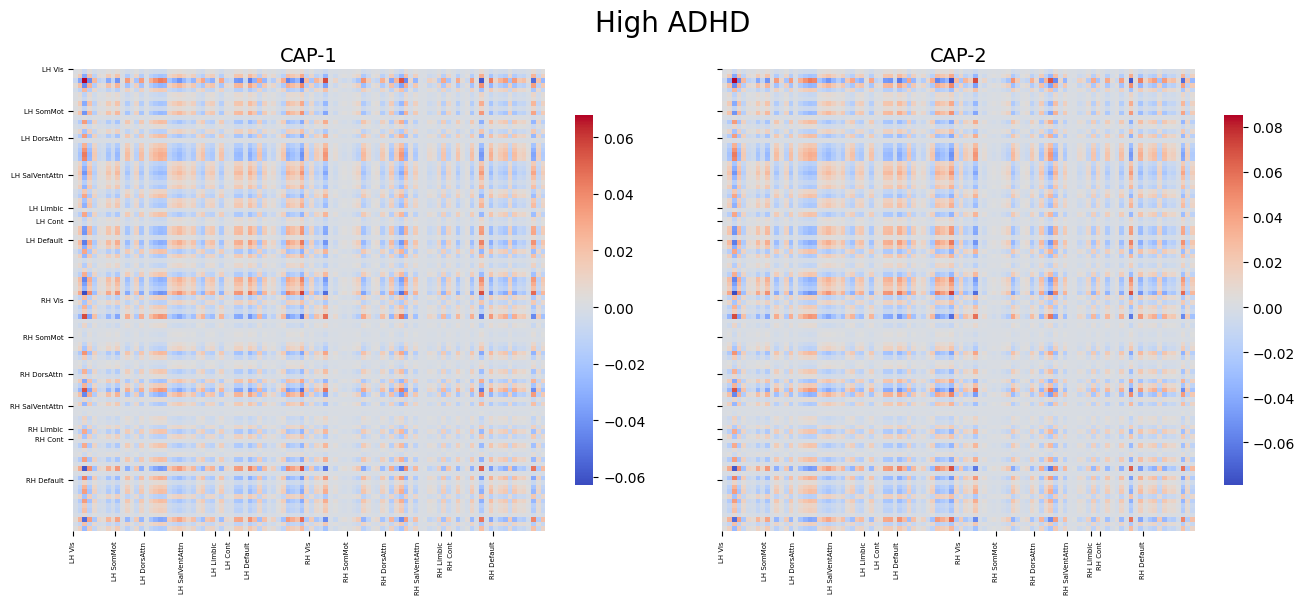

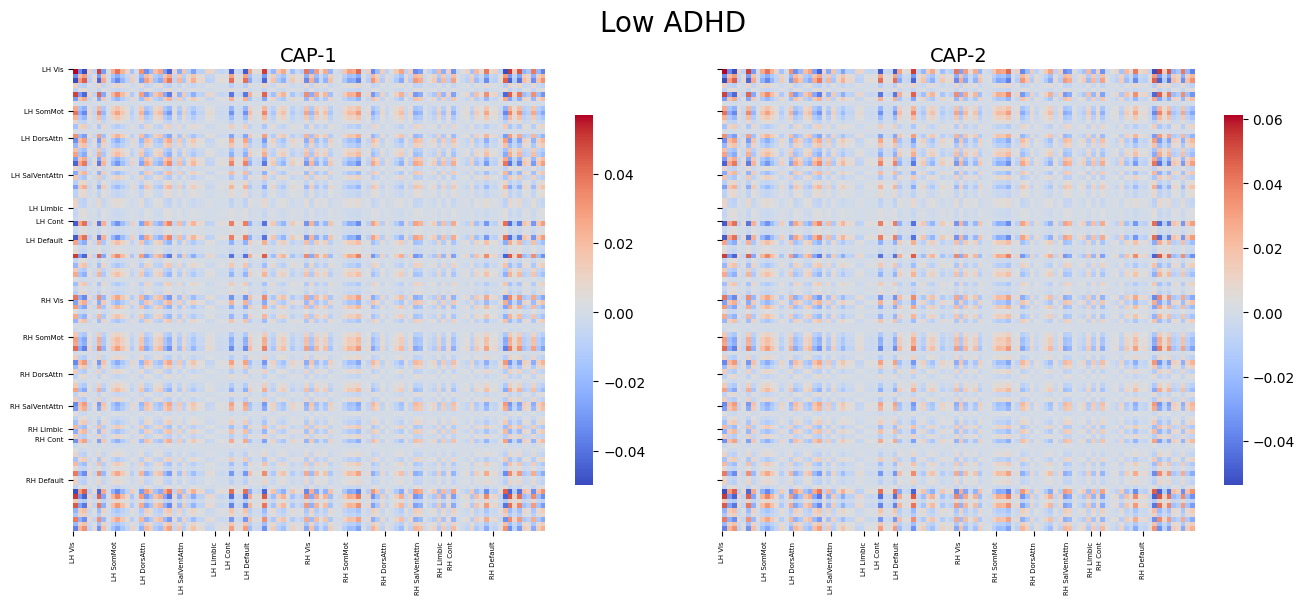

In [14]:
cap_analysis.caps2plot(yticklabels_size=5, wspace = 0.1, subplots = True, visual_scope="nodes", xlabel_rotation=90,
                       xticklabels_size = 5, hspace = 0.6, tight_layout = False)

 <font size="3">Visualizing CAPs as heatmaps at the regional level and using the `hemishere_labels` parameter to label the left and right hemispheres using `caps2plot` method.</font>

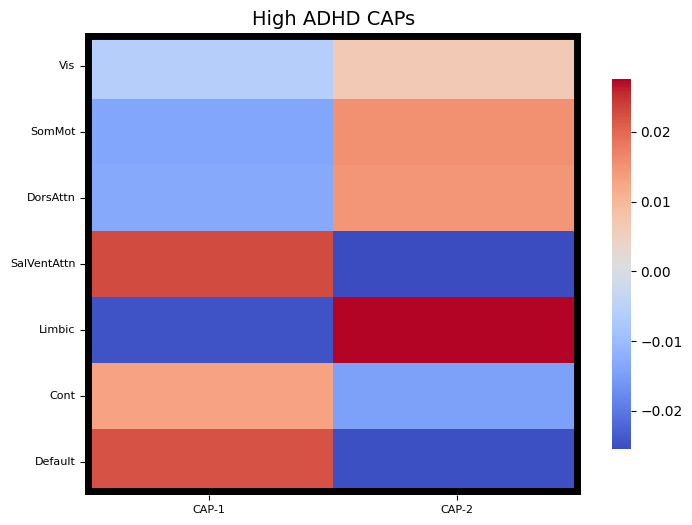

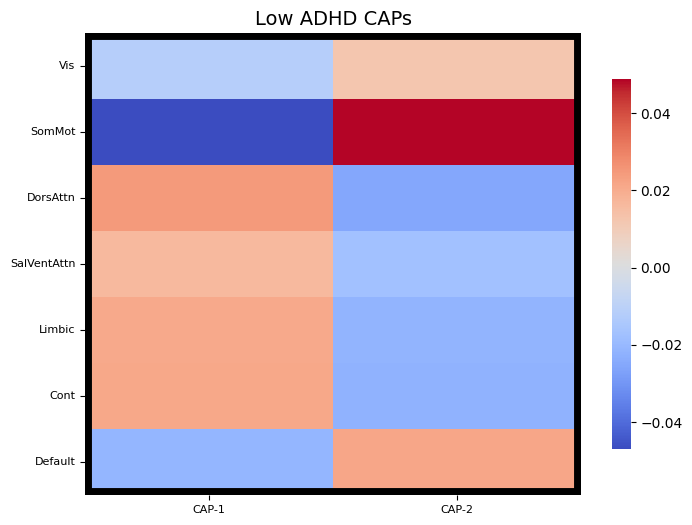

In [15]:
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10)

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the merged dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When merged, only subjects that have at least a single run across sessions will be returned in the merged dictionary. When `return_reduced_dicts` is True, only the subjects in the merged dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "merged" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [16]:
# Individual plots. In the event you wnat to merge TRs from two dictionaries conatining the same subject to find common CAPs across a task
subject_timeseries_1 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,11)}
subject_timeseries_2 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,7)}

# Returns merged dictionary as well as the reduced subject dictionaries containing only the subjects present in the merged
all_dicts = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                        return_merged_dict=True, return_reduced_dicts=True)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["merged"].keys())

dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])


 <font size="3">Generating examples not using the `group` parameter. When `group` is not defined, then the default group name is "All Subjects". Note, some additional plotting and non-plotting methods are shown below, all methods in the `CAP` class works regardless if `group` is None or defined since plots are generated for each group.</font>

In [17]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)
cap_analysis.get_caps(subject_timeseries=all_dicts["merged"], n_clusters=3)

In [18]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_0"],return_df=True, runs=[1,2])
output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All_Subjects,run-1,0.38,0.31,0.31
1,1,All_Subjects,run-2,0.23,0.40,0.37
2,2,All_Subjects,run-1,0.44,0.27,0.29
3,2,All_Subjects,run-2,0.29,0.38,0.33
4,3,All_Subjects,run-1,0.35,0.30,0.35
5,3,All_Subjects,run-2,0.29,0.33,0.38
6,4,All_Subjects,run-1,0.46,0.25,0.29
7,4,All_Subjects,run-2,0.30,0.42,0.28
8,5,All_Subjects,run-1,0.36,0.34,0.30
9,5,All_Subjects,run-2,0.35,0.28,0.37


In [19]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_1"],return_df=True, runs=[1,2], continuous_runs=True)
output["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All_Subjects,continuous_runs,1.720930,1.288889,1.789474
1,2,All_Subjects,continuous_runs,1.538462,1.418605,1.755556
2,3,All_Subjects,continuous_runs,1.392857,1.208333,1.306122
3,4,All_Subjects,continuous_runs,1.380952,1.382979,1.711111
4,5,All_Subjects,continuous_runs,1.487179,1.312500,1.755556
5,6,All_Subjects,continuous_runs,1.595745,1.565217,1.394737


In [20]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_1"],return_df=True, runs=[1,2])
output["transition_frequency"]

,Subject_ID,Group,Run,Transition_Frequency
0,1,All_Subjects,run-1,57
1,1,All_Subjects,run-2,67
2,2,All_Subjects,run-1,63
3,2,All_Subjects,run-2,62
4,3,All_Subjects,run-1,76
5,3,All_Subjects,run-2,75
6,4,All_Subjects,run-1,68
7,4,All_Subjects,run-2,64
8,5,All_Subjects,run-1,60
9,5,All_Subjects,run-2,71


 <font size="3">Visualizing CAPs as outer product heatmap at the network level using `caps2plot` method with the `subplots` parameter set to True.</font>

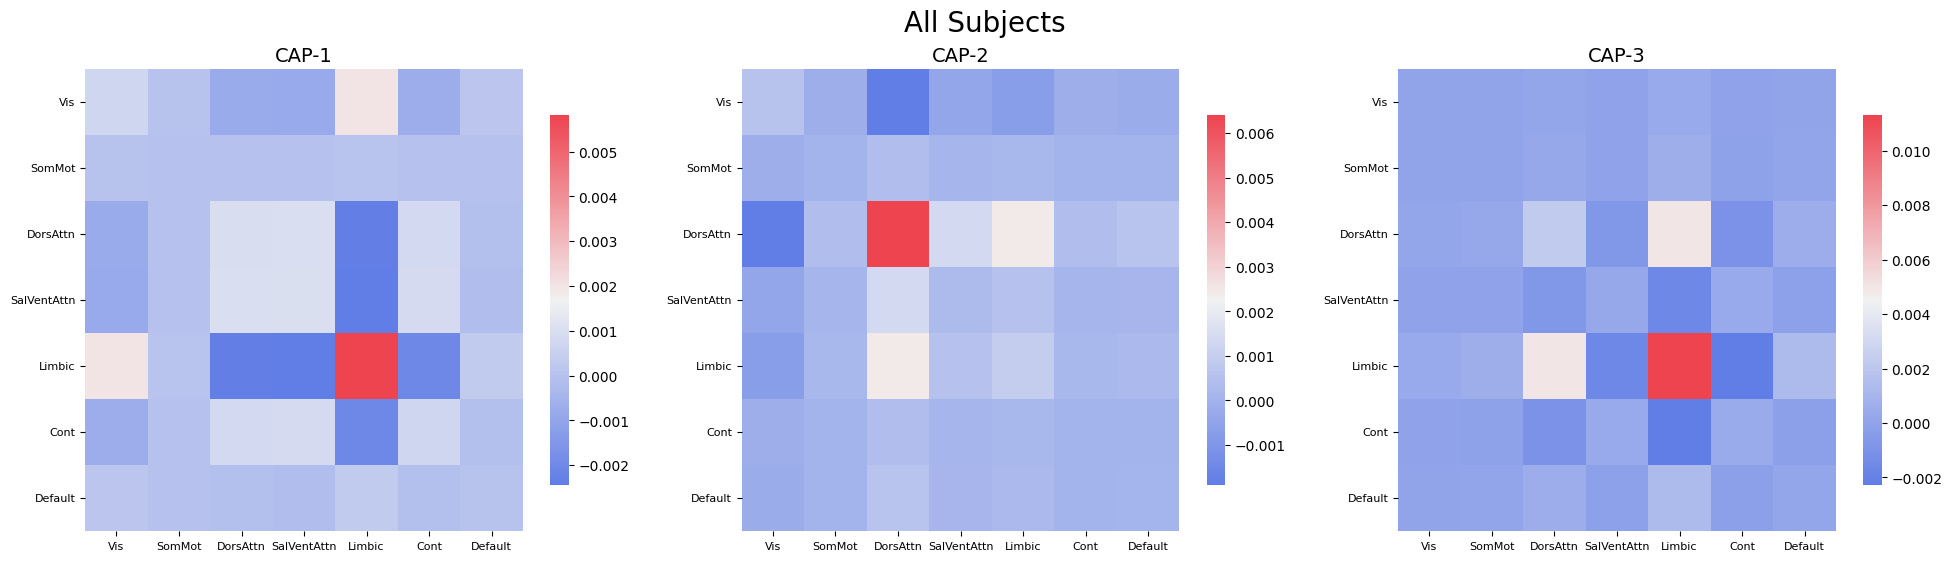

In [21]:
import seaborn as sns
sns.diverging_palette(145, 300, s=60, as_cmap=True)
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer_product", subplots=True, fontsize=14, ncol=6,
                       sharey=False, tight_layout=False, xlabel_rotation=0, hspace = 0.3, cmap=palette)

`caps2corr` can be used to obtain the Pearson correlation between CAPs and to obtain a dataframe of the uncorrected p-values.

,CAP-1,CAP-2,CAP-3
CAP-1,1 (0)***,-0.51 (4.8e-08)***,-0.5 (1e-07)***
CAP-2,-0.51 (4.8e-08)***,1 (0)***,-0.48 (3.3e-07)***
CAP-3,-0.5 (1e-07)***,-0.48 (3.3e-07)***,1 (0)***


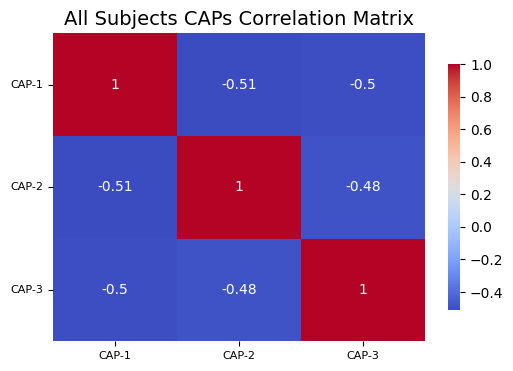

In [22]:
corr_df = cap_analysis.caps2corr(annot=True, figsize=(6,4), return_df=True)
corr_df["All Subjects"]

 <font size="3">Visualizing CAPs as surface plots using `caps2surf` method.</font>

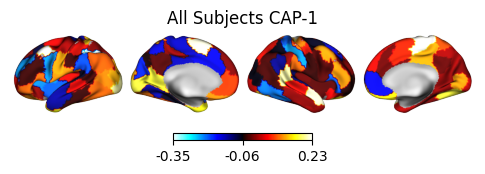

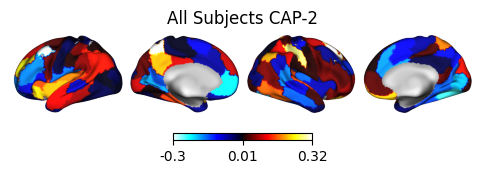

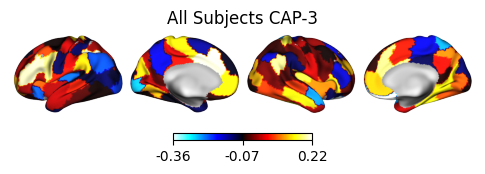

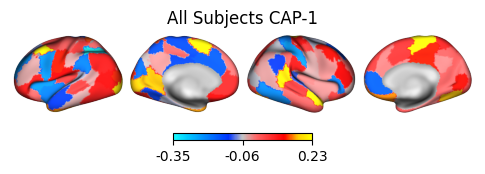

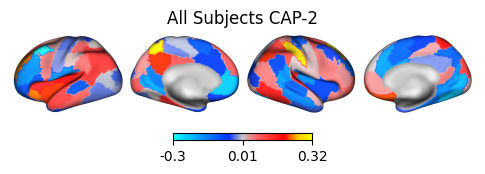

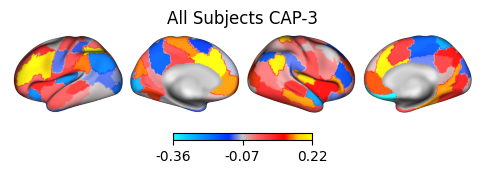

In [23]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#1bfffe", "#00ccff", "#0099ff", "#0066ff", "#0033ff", "#c4c4c4", "#ff6666", 
          "#ff3333", "#FF0000","#ffcc00","#FFFF00"]

cap_analysis.caps2surf(cmap="cold_hot", layout="row",  size=(500, 100))
# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)
cap_analysis.caps2surf(cmap=custom_cmap, size=(500, 100), layout="row", surface="veryinflated")

 <font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse (such has having many unassigned voxels on the cortical surface that makes the surface plots look patchy), there is a `knn_dict` parameter in both `caps2surf` and `caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the background boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference.</font>

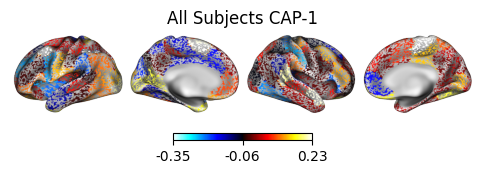

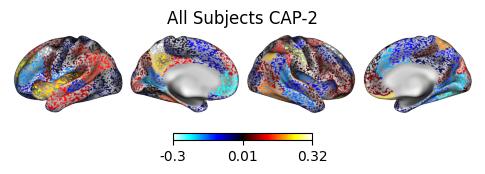

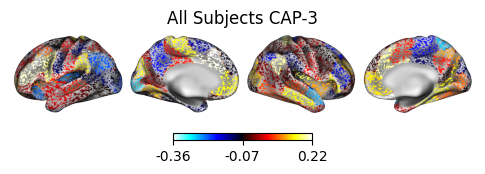

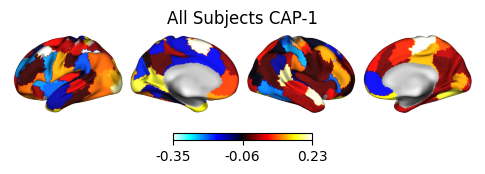

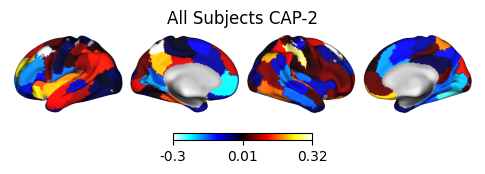

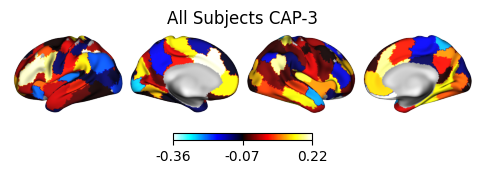

In [24]:
# Rough example that adds zeroes to some non-zero, labeled voxels
schaefer = nib.load(cap_analysis.parcel_approach["Schaefer"]["maps"])
schaefer_shape = schaefer.shape
flat_schaefer = schaefer.get_fdata().flatten()
target_indices = np.where(flat_schaefer != 0)[0]
n = int(len(target_indices) * 0.30)
random_indices = np.random.choice(target_indices, size=n, replace=False)
flat_schaefer[random_indices] = 0
reshape_schaefer = nib.Nifti1Image(np.reshape(flat_schaefer, schaefer_shape), affine=schaefer.affine, header=schaefer.header)
nib.save(reshape_schaefer,"sparse_schaefer_for_neurocaps_demo.nii.gz")
# Storing modified Schaefer in "maps" sub-key of parcel_approach
cap_analysis.parcel_approach["Schaefer"]["maps"] = "sparse_schaefer_for_neurocaps_demo.nii.gz"
# Generating a sparse issue
cap_analysis.caps2surf(cmap="cold_hot", layout="row", size=(500, 100), method="nearest")
# Fix sparse issue with knn; takes about 2 for this cell
cap_analysis.caps2surf(cmap="cold_hot", layout="row", size=(500, 100), method="nearest", knn_dict={"k":5, "resolution_mm":1})

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files. These same files can also be saved when using `caps2surf`. Additionally, this function also has the `knn_dict` parameter.</font>

In [25]:
#cap_analysis.caps2niftis(output_dir=output_dir, suffix_file_name="for_neurocaps_demo", knn_dict={"k":5, "resolution_mm":1})
cap_analysis.caps2niftis(output_dir=output_dir, suffix_file_name="for_neurocaps_demo")

 <font size="3">Radar plots showing the cosine of each network/region can be produced for each CAP to show the dominant network/regions for each CAP. There are three ways cosine similarity is calculated that primarily influence the norming in the denominator for cosine similarity - "traditional" (the traditional cosine similarity calculation that uses the full CAP vector), "selective" (filters out only the relevant  nodes in the CAP vector to assess internal consistency within a network for each CAP), "combined" (a weighted approach for both where the weight is determined by the `alpha` parameter). The default is "traditional" and the cosine similarities are stored in the `self.cosine_similarity` property.</font>

In [26]:
radialaxis={"showline": True, "linewidth": 2, "linecolor": "rgba(0, 0, 0, 0.25)", "gridcolor": "rgba(0, 0, 0, 0.25)",
            "ticks": "outside" , "tickfont": {"size": 14, "color": "black"}, "range": [0,0.3],
            "tickvals": [0.1,0.2,0.3]}
cap_analysis.caps2radar(method="traditional", radialaxis=radialaxis, fill="toself")

In [27]:
import pandas as pd
pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"])

,regions,CAP-1,CAP-2,CAP-3
0,Vis,0.088416,-0.078034,-0.010924
1,SomMot,0.001769,0.014952,-0.016893
2,DorsAttn,-0.097429,0.246736,-0.150281
3,SalVentAttn,-0.090129,0.048074,0.042916
4,Limbic,0.138315,0.054515,-0.195406
5,Cont,-0.078080,0.015433,0.063650
6,Default,0.015578,0.030166,-0.046269


 <font size="3">The neurocaps package uses nilearn to obtain the "maps" and "nodes" for the Schaefer and AAL atlases, then uses some Python code to create a list of "regions" using the "nodes" list. Neurocaps can also accept additional parcellations (as long as they are lateralized since the current iteration of the codebase assumes an "lh" and "rh" key for each region but this may be changed in a future update. Below is an example using the HCPex atlas from [wayalan Github](https://github.com/wayalan/HCPex/) for the `CAP` class.</font>

In [28]:
import subprocess
# First, retrieve the map and labels from wayalan Github
os.makedirs("neurocaps_demo_files",exist_ok=True)

if sys.platform != "win32":
    cmd = f"""
    cd neurocaps_demo_files &&
    wget https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt &&
    wget https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz
    """
    subprocess.run(cmd,check=True)
else:
    target_dir = os.path.dirname(__vsc_ipynb_file__)
    cmd = [
        ["curl", "-L", "-o", f"{target_dir}\\neurocaps_demo_files\\HCPex_LookUpTable.txt", "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt"],
        ["curl", "-L", "-o", f"{target_dir}\\neurocaps_demo_files\\HCPex.nii.gz", "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz"]
    ]
    
    for command in cmd:
        subprocess.run(command, check=True)

# Creating custom parcel approach dictionary
parcel_approach = {"Custom": {}}
# Setting the "maps"; this is needed for `TimeseriesExtractore.get_bold()` and `CAP.caps2niftis` and `CAP.cap2surf`
parcel_approach["Custom"]["maps"] = os.path.join(f"{target_dir}","neurocaps_demo_files","HCPex.nii.gz")
# Setting the "nodes"; needed for "TimeseriesExtractor.visualize_bold"; Getting nodes that don't correspond to background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(os.path.join(f"{target_dir}","neurocaps_demo_files","HCPex_LookUpTable.txt"), sep=None)["Label"].values[1:]
# Needed for many plotting methods; Setting the region names and their corresponding indices in the nodes list, in this case it is just the label id - 1
parcel_approach["Custom"]["regions"]  = {
    "Primary Visual": {"lh": [0], "rh": [180]},
    "Early Visual": {"lh": [1, 2, 3], "rh": [181, 182, 183]},
    "Dorsal Stream Visual": {"lh": list(range(4, 10)), "rh": list(range(184, 190))},
    "Ventral Stream Visual": {"lh": list(range(10, 17)), "rh": list(range(190, 197))},
    "MT+ Complex": {"lh": list(range(17, 26)), "rh": list(range(197, 206))},
    "SomaSens Motor": {"lh": list(range(26, 31)), "rh": list(range(206, 211))},
    "ParaCentral MidCing": {"lh": list(range(31, 40)), "rh": list(range(211, 220))},
    "Premotor": {"lh": list(range(40, 47)), "rh": list(range(220, 227))},
    "Posterior Opercular": {"lh": list(range(47, 52)), "rh": list(range(227, 232))},
    "Early Auditory": {"lh": list(range(52, 59)), "rh": list(range(232, 239))},
    "Auditory Association": {"lh": list(range(59, 67)), "rh": list(range(239, 247))},
    "Insula FrontalOperc": {"lh": list(range(67, 79)), "rh": list(range(247, 259))},
    "Medial Temporal": {"lh": list(range(79, 87)), "rh": list(range(259, 267))},
    "Lateral Temporal": {"lh": list(range(87, 95)), "rh": list(range(267, 275))},
    "TPO": {"lh": list(range(95, 100)), "rh": list(range(275, 280))},
    "Superior Parietal": {"lh": list(range(100, 110)), "rh": list(range(280, 290))},
    "Inferior Parietal": {"lh": list(range(110, 120)), "rh": list(range(290, 300))},
    "Posterior Cingulate": {"lh": list(range(120, 133)), "rh": list(range(300, 313))},
    "AntCing MedPFC": {"lh": list(range(133, 149)), "rh": list(range(313, 329))},
    "OrbPolaFrontal": {"lh": list(range(149, 158)), "rh": list(range(329, 338))},
    "Inferior Frontal": {"lh": list(range(158, 167)), "rh": list(range(338, 347))},
    "Dorsolateral Prefrontal": {"lh": list(range(167, 180)), "rh": list(range(347, 360))},
    "Subcortical Regions": {"lh": list(range(360, 393)), "rh": list(range(393, 426))}
}
# Saving the dictionary as a pickle file
with open(f"{os.path.join(target_dir,"neurocaps_demo_files", "HCPex_dict.pkl")}", "wb") as f:
    joblib.dump(parcel_approach, f)

In [29]:
# Creating new subject timeseries that has 426 columns
subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,426) for y in range(1,4)} for x in range(1,11)}
cap_analysis = CAP(parcel_approach=os.path.join(target_dir,"neurocaps_demo_files", "HCPex_dict.pkl"))
cap_analysis.get_caps(subject_timeseries=subject_timeseries, cluster_selection_method="variance_ratio", n_clusters=list(range(2,11)))
# The `parcel_approach`` can be set using the dictionary format when initializing the `CAP`` class or using the `parcel_approach`` property as a setter
# cap_analysis.parcel_approach = parcel_approach
# cap_analysis.parcel_approach = os.path.join(target_dir,"neurocaps_demo_files", "HCPex_dict.pkl")

[GROUP: All Subjects | METHOD: variance_ratio] - Optimal cluster size is 2.


 <font size="3">For "Custom" parcel approaches, all visualization methods can be used. </font>

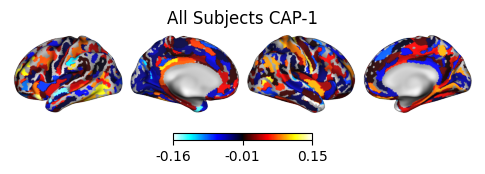

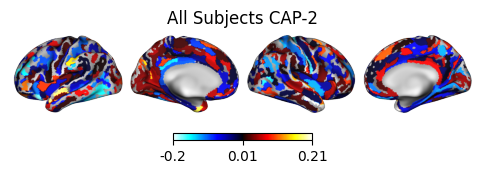

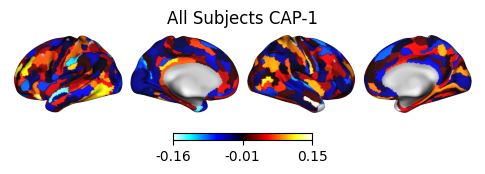

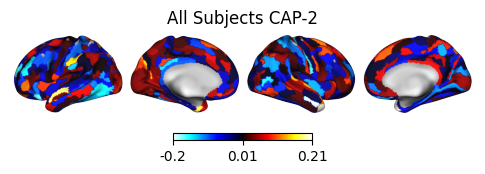

In [30]:
# Plotting with caps2surf with sparsity issue
cap_analysis.caps2surf(size=(500, 100), layout="row", method="nearest")
cap_analysis.caps2surf(size=(500, 100), layout="row", method="nearest", knn_dict={"k":5, "resolution_mm": 1})

In [31]:
radialaxis={"showline": True, "linewidth": 2, "linecolor": "rgba(0, 0, 0, 0.25)", "gridcolor": "rgba(0, 0, 0, 0.25)",
            "ticks": "outside" , "tickfont": {"size": 14, "color": "black"}, "range": [0,0.3],
            "tickvals": [0.1,0.2,0.3]}
color_discrete_map = {"High Amplitude": "rgba(255, 165, 0, 0.75)", "Low Amplitude": "black"}
cap_analysis.caps2radar(method="traditional", radialaxis=radialaxis, fill="toself", color_discrete_map=color_discrete_map, use_scatterpolar=True)


List of confound regressors that will be used during timeseries extraction if available in confound
dataframe - ['cosine*', 'trans_x', 'trans_x_derivative1', 'trans_y', 'trans_y_derivative1', 'trans_z', 'trans_z_derivative1', 'rot_x', 'rot_x_derivative1', 'rot_y', 'rot_y_derivative1', 'rot_z', 'rot_z_derivative1', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05'].


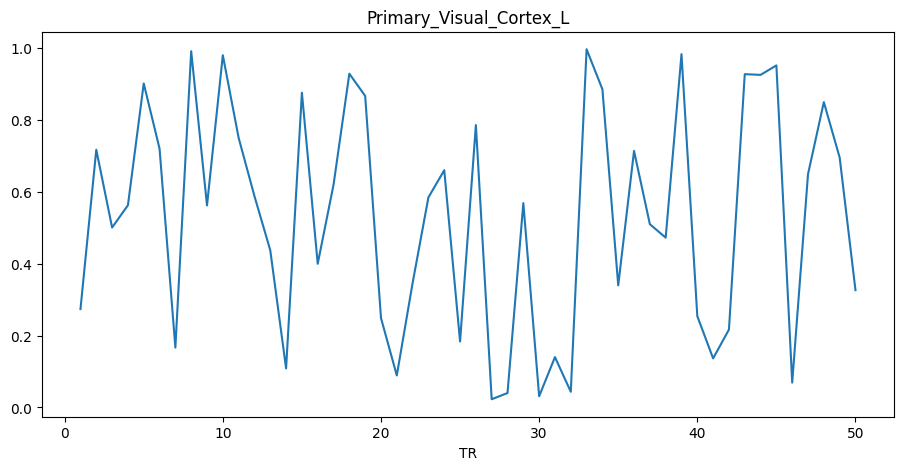

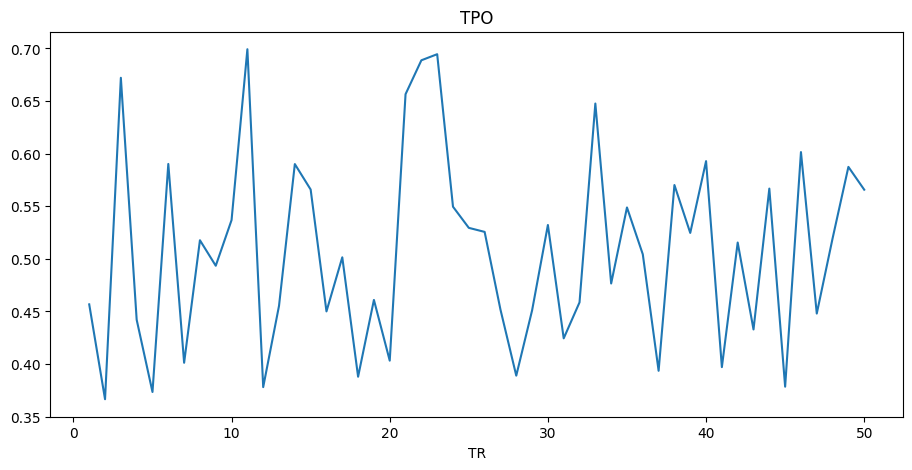

In [32]:
extractor.parcel_approach = os.path.join(target_dir,"neurocaps_demo_files", "HCPex_dict.pkl") # Can also just set it
extractor = TimeseriesExtractor(parcel_approach=os.path.join(target_dir,"neurocaps_demo_files", "HCPex_dict.pkl"))
# Subject timeseries also acts as a setter if the `visualize_bold` method needs to be used
extractor.subject_timeseries = subject_timeseries
with open("sample_for_neurocaps_demo_timeseries_HCPex.pkl", "wb") as f:
    joblib.dump(subject_timeseries,f)
extractor.subject_timeseries = "sample_for_neurocaps_demo_timeseries_HCPex.pkl"
extractor.visualize_bold(subj_id="1", run=1, roi_indx=0)
extractor.visualize_bold(subj_id="1", run=1, region="TPO")

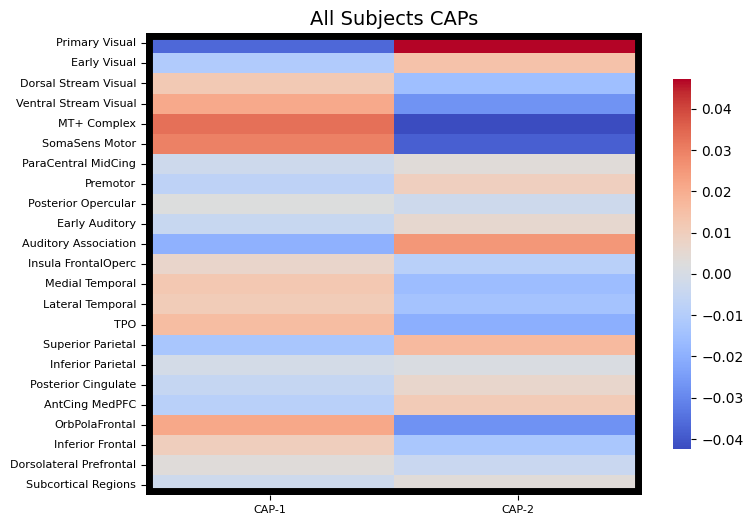

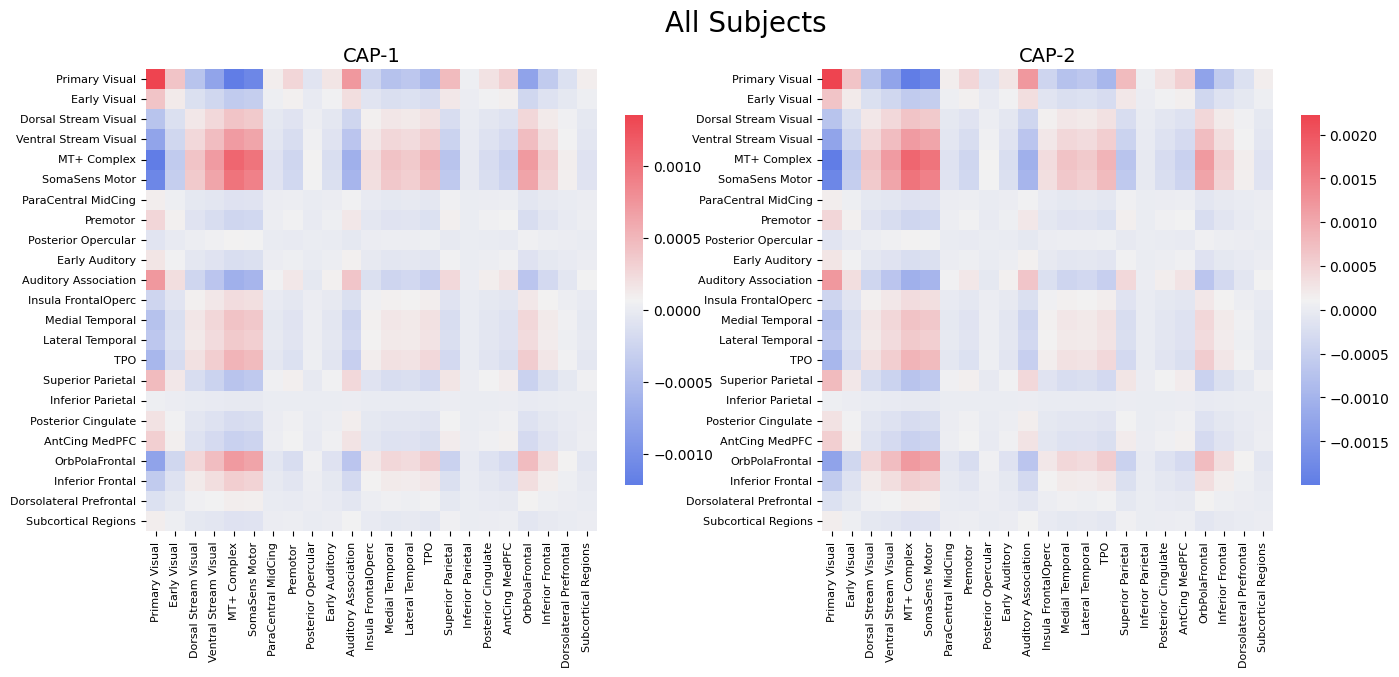

In [33]:
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer_product", subplots=True, fontsize=14, ncol=6,
                       sharey=False, tight_layout=False, xlabel_rotation=90, hspace = 0.3, cmap=palette)


 <font size="3">`caps2corr` only depends on the CAPs and `calculate_metrics` only depends on the timeseries.</font>

,Subject_ID,Group,Run,CAP-1,CAP-2
0,1,All_Subjects,continuous_runs,3.945946,4.162162
1,2,All_Subjects,continuous_runs,5.090909,3.882353
2,3,All_Subjects,continuous_runs,4.756757,3.351351
3,4,All_Subjects,continuous_runs,4.432432,3.578947
4,5,All_Subjects,continuous_runs,4.263158,3.729730
5,6,All_Subjects,continuous_runs,4.944444,3.388889
6,7,All_Subjects,continuous_runs,4.944444,3.485714
7,8,All_Subjects,continuous_runs,5.878788,3.212121
8,9,All_Subjects,continuous_runs,3.804878,3.512195
9,10,All_Subjects,continuous_runs,4.432432,3.777778


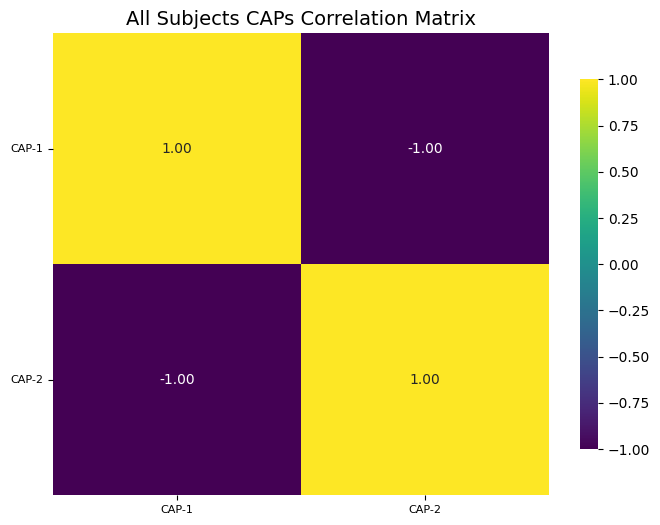

In [34]:
cap_analysis.caps2corr(annot=True, cmap="viridis", fmt=".2f")
cap_analysis.calculate_metrics(subject_timeseries="sample_for_neurocaps_demo_timeseries_HCPex.pkl",tr=2,continuous_runs=True)["persistence"]

 <font size="3">Removes the files and directories generated in this demo.</font>

In [35]:
os.remove("sample_for_neurocaps_demo_timeseries.pkl")
os.remove("sparse_schaefer_for_neurocaps_demo.nii.gz")
os.remove("sample_for_neurocaps_demo_timeseries_HCPex.pkl")
[os.remove(x) for x in ["All_Subjects_CAP_1_for_neurocaps_demo.nii.gz", "All_Subjects_CAP_2_for_neurocaps_demo.nii.gz", "All_Subjects_CAP_3_for_neurocaps_demo.nii.gz"]]
import shutil
shutil.rmtree("neurocaps_demo_files", ignore_errors=True)